 # LDpred-2
 
 Author: Shing Wan Choi

## Required data and files

[data link](https://drive.google.com/file/d/1x_G0Gxk9jFMY-PMqwtg6-vdEyUPp5p5u/view)

\begin{array}{c|c}
\hline \text { File Name } & \text { Description } \\
\hline \text { Height.QC.gz } & \text { The post-QCed summary statistic } \\
\hline \text { EUR.QC.bed } & \text { The genotype file after performing some basic filtering } \\
\hline \text { EUR.QC.bim } & \text { This file contains the SNPs that passed the basic filtering } \\
\hline \text { EUR.QC.fam } & \text { This file contains the samples that passed the basic filtering } \\
\hline \text { EUR.height } & \text { This file contains the phenotype of the samples } \\
\hline \text { EUR.cov } & \text { This file contains the covariates of the samples } \\
\hline \text { EUR.eigenvec } & \text { This file contains the PCs of the samples } \\
\hline
\end{array}

While we do provide a rough guide on how to **perform LDpred on bed files separated into individual chromosomes**, this script is untested and extra caution is required

## Prepare workspace

In [2]:
library(bigsnpr)
# options(bigstatsr.check.parallel.blas = FALSE)
# options(default.nproc.blas = NULL)

Loading required package: bigstatsr



In [3]:
library(data.table)
library(magrittr)
phenotype <- fread("post-qc/EUR.height")
covariate <- fread("post-qc/EUR.cov")
pcs <- fread("post-qc/EUR.eigenvec") # principle components
# rename columns
colnames(pcs) <- c("FID","IID", paste0("PC",1:6))
# generate required table
pheno <- merge(phenotype, covariate) %>%
    merge(., pcs)

In [8]:
head(pheno)
dim(pheno)

FID,IID,Height,Sex,PC1,PC2,PC3,PC4,PC5,PC6
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HG00096,HG00096,169.1322,1,0.000643305,0.0664323,-1.47374e-02,-0.03599560,-0.0163573,-0.02093710
HG00097,HG00097,171.2563,2,0.001413780,0.0736016,8.81567e-03,-0.02058210,-0.0116844,0.02240870
HG00099,HG00099,171.5344,2,0.002646810,0.0717702,-2.09757e-02,-0.00608687,-0.0141427,-0.00713368
HG00101,HG00101,169.8502,1,0.001697520,0.0854445,-1.56991e-02,-0.00289015,-0.0335167,-0.01411770
HG00102,HG00102,172.7884,2,0.004411350,0.0696362,1.75584e-06,-0.02643000,-0.0477571,-0.03144630
HG00103,HG00103,169.8630,1,-0.004312160,0.0571794,-8.19476e-03,-0.01349190,0.0159968,-0.01206940


[1] 472  10

## obtain HapMap3 SNPs

load HapMap3 SNPs

In [4]:
info <- readRDS(url("https://github.com/privefl/bigsnpr/raw/master/data-raw/hm3_variants.rds"))

In [2]:
head(info,10)


,chr,rsid,pos,a1,a0,maf,pos_hg19,pos_hg17
,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<int>
1,1,rs3131972,752721,A,G,0.16100,762858,802721
2,1,rs3131969,754182,A,G,0.12820,764319,804182
3,1,rs1048488,760912,C,T,0.16000,771049,810912
4,1,rs12562034,768448,A,G,0.09245,778585,818448
5,1,rs4040617,779322,G,A,0.11830,789459,829322
6,1,rs4970383,838555,A,C,0.23860,848692,888555
7,1,rs4475691,846808,T,C,0.18390,856945,896808
8,1,rs1806509,853954,C,A,0.39660,864091,903954
9,1,rs7537756,854250,G,A,0.19280,864387,904250


## Load and transform the summary statistic file

one must rename the columns according to their actual ordering

In [6]:
# Read in the summary statistic file
sumstats <- bigreadr::fread2("post-qc/Height.QC.gz") 
# LDpred 2 require the header to follow the exact naming
names(sumstats) <-
    c("chr",
    "pos",
    "rsid",
    "a1",
    "a0",
    "n_eff",
    "beta_se",
    "p",
    "OR",
    "INFO",
    "MAF")
# Transform the OR into log(OR)
sumstats$beta <- log(sumstats$OR)


In [7]:
head(sumstats)
nrow(sumstats)
# Filter out hapmap SNPs
sumstats <- sumstats[sumstats$rsid %in% info$rsid,]
head(sumstats)
nrow(sumstats)
write.csv(sumstats, file = "sumstats.csv")



,chr,pos,rsid,a1,a0,n_eff,beta_se,p,OR,INFO,MAF,beta
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,756604,rs3131962,A,G,388028,0.00301666,0.483171,0.9978869,0.8905579,0.3693896,-0.00211532
2,1,768448,rs12562034,A,G,388028,0.00329472,0.834808,1.0006873,0.8958935,0.3368458,0.00068708
3,1,779322,rs4040617,G,A,388028,0.00303344,0.428970,0.9976036,0.8975083,0.3773680,-0.00239932
4,1,801536,rs79373928,G,T,388028,0.00841324,0.808999,1.0020357,0.9089629,0.4832122,0.00203363
5,1,808631,rs11240779,G,A,388028,0.00242821,0.590265,1.0013083,0.8932125,0.4504096,0.00130747
6,1,809876,rs57181708,G,A,388028,0.00336785,0.714750,1.0012317,0.9235576,0.4997439,0.00123090


[1] 499617

,chr,pos,rsid,a1,a0,n_eff,beta_se,p,OR,INFO,MAF,beta
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,1,768448,rs12562034,A,G,388028,0.00329472,0.834808000,1.0006873,0.8958935,0.3368458,0.00068708
3,1,779322,rs4040617,G,A,388028,0.00303344,0.428970000,0.9976036,0.8975083,0.3773680,-0.00239932
8,1,838555,rs4970383,A,C,388028,0.00235773,0.150993000,0.9966199,0.9077165,0.3271640,-0.00338578
18,1,873558,rs1110052,G,T,388028,0.00225578,0.000285674,0.9918494,0.9004758,0.3680888,-0.00818396
19,1,880238,rs3748592,A,G,388028,0.00450310,0.488653000,1.0031231,0.8728364,0.4104163,0.00311819
20,1,880390,rs3748593,A,C,388028,0.00635197,0.272881000,0.9930596,0.8992809,0.4930243,-0.00696463


[1] 136004

##  Calculate the LD matrix

Genome Wide bed file

In [12]:
# Get maximum amount of cores
NCORES <- nb_cores()
# Open a temporary file
tmp <- tempfile(tmpdir = "tmp-dataset")
on.exit(file.remove(paste0(tmp, ".sbk")), add = TRUE)
# Initialize variables for storing the LD score and LD matrix
corr <- NULL
ld <- NULL
# We want to know the ordering of samples in the bed file 
fam.order <- NULL
# preprocess the bed file (only need to do once for each data set)
#snp_readBed("post-qc/EUR.QC.bed")

# now attach the genotype object
obj.bigSNP <- snp_attach("post-qc/EUR.QC.rds")

# extract the SNP information from the genotype
map <- obj.bigSNP$map[-3]
names(map) <- c("chr", "rsid", "pos", "a1", "a0")
# perform SNP matching
info_snp <- snp_match(sumstats, map)
# Assign the genotype to a variable for easier downstream analysis
genotype <- obj.bigSNP$genotypes
# Rename the data structures
CHR <- map$chr
POS <- map$pos
# get the CM information from 1000 Genome
# will download the 1000G file to the current directory (".")
POS2 <- snp_asGeneticPos(CHR, POS, dir = ".")



Warning message in file.remove(paste0(tmp, ".sbk")):
"cannot remove file 'tmp-dataset/file9d15a821f6e.sbk', reason 'No such file or directory'"
136,004 variants to be matched.

0 ambiguous SNPs have been removed.

134,522 variants have been matched; 0 were flipped and 91 were reversed.



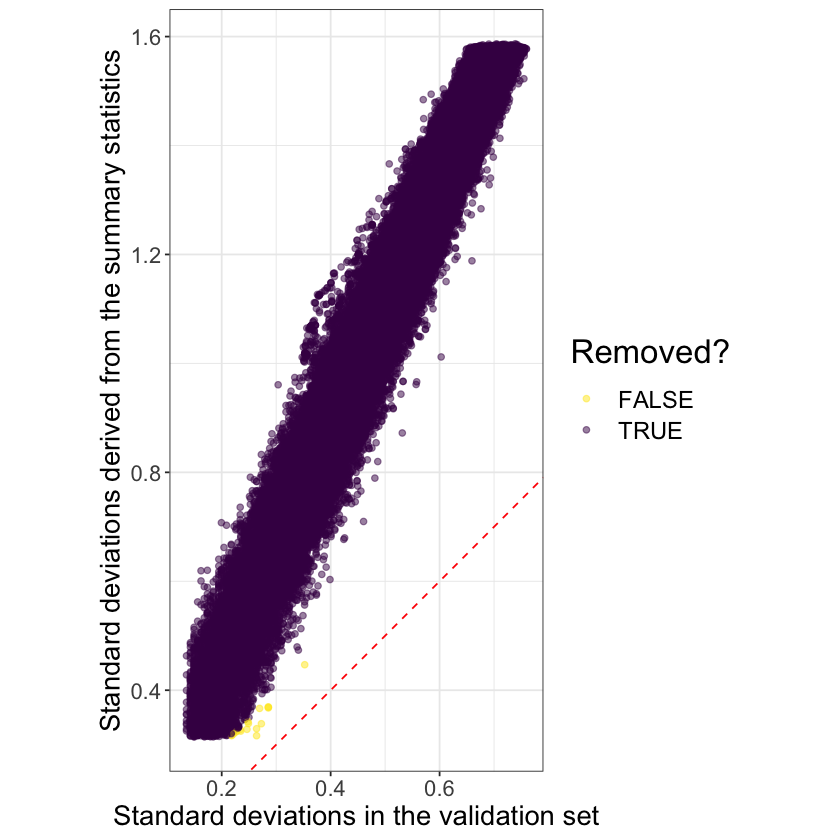

In [11]:
ind.val = 1:nrow(genotype)
    sd <- runonce::save_run(
      sqrt(big_colstats(genotype, ind.val, ncores = NCORES)$var),
      file = "sd.rds"
    )

    sd_val <- sd[info_snp$`_NUM_ID_`]

    sd_ss <- with(info_snp, 2 / sqrt(n_eff * beta_se^2))

    is_bad <-
      sd_ss < (0.5 * sd_val) | sd_ss > (sd_val + 0.1) | sd_ss < 0.1 | sd_val < 0.05
    library(tidyverse)
    qplot(sd_val, sd_ss, color = is_bad, alpha = I(0.5)) +
      theme_bigstatsr() +
      coord_equal() +
      scale_color_viridis_d(direction = -1) +
      geom_abline(linetype = 2, color = "red") +
      labs(x = "Standard deviations in the validation set",
           y = "Standard deviations derived from the summary statistics",
           color = "Removed?")



In [14]:
is_bad

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [61]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [73]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [97]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [109]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [121]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [133]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [145]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [157]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [169]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [181]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [193]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [205]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [217]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [229]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [241]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [253]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [265]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [277]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [289]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [301]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [313]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [325]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [337]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [349]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [361]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [373]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [385]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [397]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [409]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [421]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [433]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [445]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [457]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [469]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [481]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [493]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [505]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [517]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [529]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [541]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [553]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [565]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [577]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [589]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [6

In [17]:
genotype[,!is_bad]

0,0,0,0,1,0,0,0,0,0,⋯,1,0,0,0,1,0,0,0,1,0
0,0,0,0,0,1,0,0,0,0,⋯,1,0,0,1,0,0,0,2,0,0
1,0,0,0,0,2,0,0,0,1,⋯,2,0,0,1,1,0,0,1,2,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,2,0,0
0,0,0,0,0,0,2,0,0,0,⋯,0,0,0,0,1,0,0,0,1,0
0,0,0,0,0,2,1,0,0,0,⋯,0,0,0,1,1,0,1,2,1,0
0,0,0,0,0,1,0,1,0,0,⋯,1,0,0,1,0,0,0,1,1,1
0,0,1,0,1,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,1,0
0,0,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,1,0,0,1,0,⋯,0,0,0,1,0,0,0,1,1,0
0,0,1,0,1,1,0,0,1,0,⋯,2,0,0,1,0,0,0,1,0,2


In [25]:
tail(info_snp)

,chr,pos,a0,a1,rsid.ss,n_eff,beta_se,p,OR,INFO,MAF,beta,_NUM_ID_.ss,rsid,_NUM_ID_
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
134517,22,51156666,C,T,rs9628187,388028,0.00250085,1.86455e-04,1.0093888,0.9010090,0.4838050,0.00934502,135999,rs9628187,489791
134518,22,51162059,G,A,rs10451,388028,0.00221267,3.64107e-02,1.0046403,0.8920235,0.3822969,0.00462960,136000,rs10451,489795
134519,22,51163138,C,T,rs715586,388028,0.00285299,3.80404e-04,0.9899135,0.8855720,0.4529913,-0.01013770,136001,rs715586,489796
134520,22,51165664,G,A,rs8137951,388028,0.00221491,4.65252e-02,1.0044187,0.9192793,0.4870702,0.00440901,136002,rs8137951,489798
134521,22,51171497,G,A,rs2301584,388028,0.00270920,4.71987e-01,0.9980533,0.9063701,0.4775257,-0.00194859,136003,rs2301584,489799
134522,22,51175626,A,G,rs3810648,388028,0.00425146,7.83096e-05,1.0169332,0.8908870,0.2903021,0.01679140,136004,rs3810648,489802


In [26]:
POS2

[1] 1.834804e-02 3.364271e-02 4.858774e-02 5.345690e-02 5.459369e-02
    [6] 1.483348e-01 1.595134e-01 1.675569e-01 1.910042e-01 1.916548e-01
   [11] 1.921624e-01 1.974940e-01 1.995367e-01 1.998224e-01 2.005195e-01
   [16] 2.014575e-01 2.038744e-01 2.061335e-01 2.061706e-01 2.064725e-01
   [21] 2.065405e-01 2.071783e-01 2.081376e-01 2.089845e-01 2.102479e-01
   [26] 2.113953e-01 2.831157e-01 2.891410e-01 2.913081e-01 2.913865e-01
   [31] 2.965590e-01 3.108981e-01 3.117341e-01 3.121837e-01 3.181392e-01
   [36] 3.236764e-01 3.250495e-01 3.291625e-01 3.364404e-01 3.377053e-01
   [41] 3.443349e-01 3.444011e-01 3.468093e-01 3.477294e-01 3.484377e-01
   [46] 3.484875e-01 3.578697e-01 3.582879e-01 3.585335e-01 3.590496e-01
   [51] 3.591955e-01 3.640094e-01 3.687782e-01 3.688962e-01 3.704206e-01
   [56] 3.856312e-01 4.050785e-01 4.060711e-01 4.078749e-01 4.079084e-01
   [61] 4.081104e-01 4.089418e-01 4.141737e-01 4.229174e-01 4.385875e-01
   [66] 4.448137e-01 4.502180e-01 4.647622e-01 4.692267e-01 4.861566e-01
   [71] 4.962955e-01 4.963372e-01 4.972014e-01 4.986145e-01 7.498732e-01
   [76] 8.518829e-01 8.521622e-01 8.524299e-01 8.529021e-01 8.536572e-01
   [81] 8.590751e-01 8.646797e-01 8.663051e-01 9.199444e-01 9.224116e-01
   [86] 9.318723e-01 9.344219e-01 9.346888e-01 9.357177e-01 9.369885e-01
   [91] 9.374048e-01 9.401511e-01 9.459970e-01 9.508740e-01 9.650952e-01
   [96] 9.669862e-01 9.753806e-01 9.761916e-01 9.828474e-01 9.889592e-01
  [101] 9.937047e-01 9.938222e-01 9.943629e-01 9.954201e-01 9.968166e-01
  [106] 9.970119e-01 9.980963e-01 9.987760e-01 1.023521e+00 1.023637e+00
  [111] 1.027869e+00 1.035251e+00 1.038085e+00 1.038334e+00 1.070415e+00
  [116] 1.076452e+00 1.080258e+00 1.084789e+00 1.092875e+00 1.103705e+00
  [121] 1.103845e+00 1.103960e+00 1.104889e+00 1.106019e+00 1.108953e+00
  [126] 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00
  [131] 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00
  [136] 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00
  [141] 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00
  [146] 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00
  [151] 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00
  [156] 1.117505e+00 1.117505e+00 1.117505e+00 1.117505e+00 1.121393e+00
  [161] 1.121606e+00 1.139225e+00 1.147873e+00 1.170801e+00 1.171055e+00
  [166] 1.171311e+00 1.172429e+00 1.173213e+00 1.173233e+00 1.173256e+00
  [171] 1.173371e+00 1.173437e+00 1.173518e+00 1.173566e+00 1.173583e+00
  [176] 1.173636e+00 1.173652e+00 1.173747e+00 1.175663e+00 1.175684e+00
  [181] 1.175702e+00 1.176024e+00 1.176908e+00 1.178864e+00 1.183896e+00
  [186] 1.184235e+00 1.184268e+00 1.186566e+00 1.186636e+00 1.193702e+00
  [191] 1.203439e+00 1.203976e+00 1.204572e+00 1.204686e+00 1.204898e+00
  [196] 1.204966e+00 1.214989e+00 1.238445e+00 1.239407e+00 1.239489e+00
  [201] 1.245231e+00 1.245659e+00 1.245844e+00 1.245874e+00 1.254131e+00
  [206] 1.256186e+00 1.268998e+00 1.352408e+00 1.354686e+00 1.369226e+00
  [211] 1.370458e+00 1.373723e+00 1.376659e+00 1.378525e+00 1.379043e+00
  [216] 1.381347e+00 1.422707e+00 1.520515e+00 1.524503e+00 1.527722e+00
  [221] 1.532823e+00 1.570698e+00 1.615299e+00 1.615441e+00 1.615562e+00
  [226] 1.622179e+00 1.628969e+00 1.629928e+00 1.633980e+00 1.642361e+00
  [231] 1.664686e+00 1.666142e+00 1.670979e+00 1.671961e+00 1.672940e+00
  [236] 1.673616e+00 1.673712e+00 1.673812e+00 1.673818e+00 1.673968e+00
  [241] 1.673990e+00 1.674004e+00 1.674081e+00 1.674764e+00 1.674867e+00
  [246] 1.675565e+00 1.677340e+00 1.677472e+00 1.677596e+00 1.682474e+00
  [251] 1.706057e+00 1.707608e+00 1.707745e+00 1.707870e+00 1.707873e+00
  [256] 1.707952e+00 1.707970e+00 1.707982e+00 1.708391e+00 1.723722e+00
  [261] 1.836323e+00 1.901632e+00 1.932287e+00 1.932652e+00 1.934448e+00
  [266] 1.936132e+00 1.944572e+00 1.950686e+00 1.954299e+00 1.955290e+00
  [271] 1.957848e+00 1.959863e+00 1.968174e+00 1.980997e+00 1.

In [ ]:
# calculate LD
for (chr in 1:22) {
    # Extract SNPs that are included in the chromosome
    ind.chr <- which(info_snp$chr == chr)
    ind.chr2 <- info_snp$`_NUM_ID_`[ind.chr]
    # Calculate the LD
    corr0 <- snp_cor(
            genotype,
            ind.col = ind.chr2,
            ncores = NCORES,
            infos.pos = POS2[ind.chr2],
            size = 3 / 1000
        )
    if (chr == 1) {
        ld <- Matrix::colSums(corr0^2)
        corr <- as_SFBM(corr0, tmp)
    } else {
        ld <- c(ld, Matrix::colSums(corr0^2))
        corr$add_columns(corr0, nrow(corr))
    }
}
# We assume the fam order is the same across different chromosomes
fam.order <- as.data.table(obj.bigSNP$fam)
# Rename fam order
setnames(fam.order,
        c("family.ID", "sample.ID"),
        c("FID", "IID"))


In [13]:
names(obj.bigSNP)
head(obj.bigSNP$genotypes)
dim(obj.bigSNP$genotypes)

[1] "genotypes" "fam"       "map"

1,1,0,1,0,0,0,1,1,1,⋯,1,0,0,0,0,0,0,0,0,0
0,0,0,1,0,1,1,2,1,2,⋯,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,1,0,0,⋯,0,0,1,0,0,1,0,1,0,1
0,0,0,0,0,1,1,0,0,0,⋯,1,0,1,0,0,0,0,1,0,1
0,0,0,0,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,2,0,0
0,0,0,0,0,0,0,0,1,1,⋯,0,0,0,0,0,0,1,1,0,0


[1]    483 489805

ERROR: Error in obj.bigSNP$genotypes == 0: comparison (1) is possible only for atomic and list types


In [11]:
head(obj.bigSNP$fam)
summary(obj.bigSNP$fam$affection)

,family.ID,sample.ID,paternal.ID,maternal.ID,sex,affection
,<chr>,<chr>,<int>,<int>,<int>,<int>
1,HG00096,HG00096,0,0,1,-9
2,HG00097,HG00097,0,0,2,-9
3,HG00099,HG00099,0,0,2,-9
4,HG00101,HG00101,0,0,1,-9
5,HG00102,HG00102,0,0,2,-9
6,HG00103,HG00103,0,0,1,-9


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     -9      -9      -9      -9      -9      -9 

In [22]:
head(obj.bigSNP$map)
dim(obj.bigSNP$map)

,chromosome,marker.ID,genetic.dist,physical.pos,allele1,allele2
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>
1,1,rs3131962,0.490722,756604,A,G
2,1,rs4040617,0.500708,779322,G,A
3,1,rs79373928,0.587220,801536,G,T
4,1,rs11240779,0.620827,808631,G,A
5,1,rs57181708,0.620827,809876,G,A
6,1,rs4422948,0.620827,835499,G,A


[1] 489805      6

# Perform LD score regression

In [ ]:
df_beta <- info_snp[,c("beta", "beta_se", "n_eff", "_NUM_ID_")]
ldsc <- snp_ldsc(   ld, 
                    length(ld), 
                    chi2 = (df_beta$beta / df_beta$beta_se)^2,
                    sample_size = df_beta$n_eff, 
                    blocks = NULL)
h2_est <- ldsc[["h2"]]
h2_est

# Estimate Beta

## Infinitesimal Model

In [ ]:
beta_inf <- snp_ldpred2_inf(corr, df_beta, h2 = h2_est)
summary(beta_inf)

## grid model

In [ ]:
# Prepare data for grid model
p_seq <- signif(seq_log(1e-4, 1, length.out = 17), 2)
h2_seq <- round(h2_est * c(0.7, 1, 1.4), 4)
grid.param <-
    expand.grid(p = p_seq,
            h2 = h2_seq,
            sparse = c(FALSE, TRUE))
# Get adjusted beta from grid model
beta_grid <-
    snp_ldpred2_grid(corr, df_beta, grid.param, ncores = NCORES)
summary(beta_grid)

## auto model

In [ ]:
# Get adjusted beta from the auto model
multi_auto <- snp_ldpred2_auto(
    corr,
    df_beta,
    h2_init = h2_est,
    vec_p_init = seq_log(1e-4, 0.9, length.out = NCORES),
    ncores = NCORES
)
beta_auto <- sapply(multi_auto, function(auto)
    auto$beta_est)
summary(beta_auto)

# Obtain model PRS

## Infinitesimal Model

In [ ]:
if(is.null(obj.bigSNP)){
    obj.bigSNP <- snp_attach("EUR.QC.rds")
}
genotype <- obj.bigSNP$genotypes
# calculate PRS for all samples
ind.test <- 1:nrow(genotype)
pred_inf <- big_prodVec(    genotype,
                            beta_inf,
                            ind.row = ind.test,
                            ind.col = info_snp$`_NUM_ID_`)
hist(pred_inf)

## Grid model

In [ ]:
if(is.null(obj.bigSNP)){
    obj.bigSNP <- snp_attach("EUR.QC.rds")
}
genotype <- obj.bigSNP$genotypes
# calculate PRS for all samples
ind.test <- 1:nrow(genotype)
pred_grid <- big_prodMat(   genotype, 
                            beta_grid, 
                            ind.col = info_snp$`_NUM_ID_`)
hist(pred_grid)

## Auto model

In [ ]:
if(is.null(obj.bigSNP)){
    obj.bigSNP <- snp_attach("EUR.QC.rds")
}
genotype <- obj.bigSNP$genotypes
# calculate PRS for all samples
ind.test <- 1:nrow(genotype)
pred_auto <-
    big_prodMat(genotype,
                beta_auto,
                ind.row = ind.test,
                ind.col = info_snp$`_NUM_ID_`)
# scale the PRS generated from AUTO
pred_scaled <- apply(pred_auto, 2, sd)
final_beta_auto <-
    rowMeans(beta_auto[,
                abs(pred_scaled -
                    median(pred_scaled)) <
                    3 * mad(pred_scaled)])
pred_auto <-
    big_prodVec(genotype,
        final_beta_auto,
        ind.row = ind.test,
        ind.col = info_snp$`_NUM_ID_`)
hist(pred_auto)